<a href="https://colab.research.google.com/github/lustraka/Data_Analysis_Workouts/blob/main/Investigate_Gapminders_WDI/Investigate_R_and_D_Expenditures_Population.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Investigate Gapminder's World Development Indicators

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#questions">Questions</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#limitation">Limitation</a></li>
</ul>

# Introduction <a id='intro'></a>

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables.
>
> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. If you're not sure what questions to ask right now, then make sure you familiarize yourself with the variables and the dataset context for ideas of what to explore.

**[Gapminder](https://www.gapminder.org/)** has collected a lot of information about how people live their lives in different countries, tracked across the years, and on a number of different indicators. The complete datasets with hundreds of indicators are available in GitHub repositories, one of which is World Development Indicators (WDI). The data is organized in loose CSV files which can be consumed by any spreadsheet software. More efficient way of consuming data is by using [DDF data model](https://open-numbers.github.io/ddf.html).

DDF is used to define datasets. A dataset is a body of coherent, related data that is composed of separate elements, but can be manipulated as one unit by a computer. Each DDF dataset must have Concepts and may have DataPoints, Entities, Metadata, or Synonyms, whereas:

- **Concepts** contain information about the variables in the data set, i.e. concept properties with simple key (concept = the column-header in a tabular format).
- **DataPoints** contain multidimensional data, i.e. indicators with composite keys (dimensions).
- **Entities** contain single-dimensional data, i.e. entity properties with simple keys (entity).

What datapoints, entities, and concepts to find in what files is defined in the schema and resources sections of a `datapackage.json` file. This is the entry point for any machine that wants to explore the data set:

In [1]:
# Import dependencies
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set path to data repozitory
path = 'https://raw.githubusercontent.com/open-numbers/ddf--open_numbers--world_development_indicators/master/'
# Read datapackage.json with data descriptions
datapkg = requests.get(path + 'datapackage.json').json()

# Print key information about a data set
for k,v in datapkg.items():
  if type(v) == str or len(v) < 3:
    print(k, ' :\t', v)
  else:
    print(k, ' : section contains ', len(v), 'elements.')

name  :	 ddf--gapminder--world_development_indicators
language  :	 {'name': 'English', 'id': 'en'}
title  :	 Gapminder's World Development Indicators
description  :	 Gapminder's World Development Indicators
author  :	 Gapminder
license  :	 MIT
created  :	 2021-08-22T12:15:33.269367+00:00
translations  :	 []
version  :	 0.0.1
resources  : section contains  2402 elements.
ddfSchema  : section contains  4 elements.


This data analysis investigates two dependent variables (indicators) related to countries:
- **Research and development expenditure (% of GDP)**
- **Total population**

A description of Research and development expenditure (concept `gb_xpd_rsdv_gd_zs`) and Total population (`sp_pop_totl`) variable is provided by `ddf--concepts--continuous.csv` file:

In [3]:
import textwrap # Wrapping long texts improves rendering of report

def get_concept_info(repository, indicator):
  """Prints key information about an indicator retrieved from a repository.
  
  Args:
    repository : A dataframe from  Gapminder World Development Indicator 
      repository describing concepts.
    indicator : An ID of an indicator.
    
  Returns:
    None"""

  print('\nConcept:', indicator)
  print('==========================')
  for v in ['name', 'long_definition', 'statistical_concept_and_methodology', 'source']:
    text = v.replace('_', ' ').capitalize() + ' : ' + str(repository.at[indicator, v])
    for line in textwrap.wrap(text, width=80):
      print(line.replace('\\n', '\n'))
    print()
  
  return None

# Load descriptions of continuous concepts
wdic_cont = pd.read_csv(path + 'ddf--concepts--continuous.csv', index_col='concept')

# Choose indicators for further analysis
indicators = ['gb_xpd_rsdv_gd_zs', 'sp_pop_totl']

# Print key information about indicators
for i in indicators:
  get_concept_info(wdic_cont, i)


Concept: gb_xpd_rsdv_gd_zs
Name : Research and development expenditure (% of GDP)

Long definition : Gross domestic expenditures on research and development (R&D),
expressed as a percent of GDP. They include both capital and current
expenditures in the four main sectors: Business enterprise, Government, Higher
education and Private non-profit. R&D covers basic research, applied research,
and experimental development.

Statistical concept and methodology : The gross domestic expenditure on R&D
indicator consists of the total expenditure (current and capital) on R&D by all
resident companies, research institutes, university and government laboratories,
etc. It excludes R&D expenditures financed by domestic firms but performed
abroad. 

The OECD's Frascati Manual defines research and experimental
development as "creative work undertaken on a systemic basis in order to
increase the stock of knowledge, including knowledge of man, culture and
society, and the use of this stock of knowledge 

# Questions <a id='questions'></a>
According to [this data story](https://www.weforum.org/agenda/2020/11/countries-spending-research-development-gdp/), investment in research and development is the lifeblood of many private sector organizations, helping bring new products and services to market. It's also important to national economies and plays a crutial role in GDP growth. Let us focus on two key questions:

1. Which countries invest most in R&D?
2. Is there a relationship between R&D expenditures and country's population?

# Data Wrangling <a id='wrangling'></a>

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

## Load Data Set
An advantage of using a data repozitory organized according to DDF data model is easy loading of clean data. For example, missing data are avoided by 'inner' method of datapoints concatenation. The steps taken to load and check data for analysis are decribed by inline comments in the next cell. Key information about data wrangling privides a log in the next cell's output.

In [4]:
def get_datapoint(path, indicator, dim = 'geo--time'):
  """Reads a datapoint for a given indicator and dimensions.

  Args:
    path : A path to Gapminder World Development Indicator repository.
    indicator : A concept name of an indicator.
    dim : Required dimensions separeted by '--'.

  Returns:
    A pandas.DataFrame indexed by dimensions (or prints non-existent path).
  """

  # Compile the path to CSV file
  path = path + 'datapoints/ddf--datapoints--' + indicator + '--by--' + dim + '.csv'
  index_col = dim.split('--')
  # Either a read csv file or print the incorrect path to check
  try:
    df = pd.read_csv(path, index_col=index_col)
    print(f'Loading {indicator} ...')
    print('Shape: ', df.shape)
    print('===== Head of a DataFrame ====')
    print(df.head(), '\n==============================\n')
    return df
  except:
    print(f'No such file at path\n{path}')
    return None


# Load research and development data
df_rad_exp = get_datapoint(path, 'gb_xpd_rsdv_gd_zs')

# Load total population data
pop_totl = get_datapoint(path, 'sp_pop_totl')

# Concatenate R&D data with GDP growth data where both values are available
df = pd.concat([df_rad_exp, pop_totl], axis=1, join='inner').reset_index()

# Shorten names of indicators
df.rename(columns={'gb_xpd_rsdv_gd_zs': 'rad_exp', 'sp_pop_totl': 'pop_totl'}, inplace=True)

# Load country data
countries = pd.read_csv(path + 'ddf--entities--geo--country.csv', index_col='country')

# Add country data into the dataframe
for col in ['name', 'income_groups', 'world_4region']:
  df[col] = df.geo.apply(lambda c: countries.at[c, col])

# Check duplicates and missing values
assert df.duplicated().sum() == 0
print('No duplicated observations.')
assert df.isna().any().any() == False
print('No missing values.')
print('Shape after concatenation and extension :', df.shape)
print('Head of a resulting data set including country data:')
df.head()

Loading gb_xpd_rsdv_gd_zs ...
Shape:  (1527, 1)
===== Head of a DataFrame ====
          gb_xpd_rsdv_gd_zs
geo time                   
alb 2007            0.08737
    2008            0.15412
are 2011            0.48920
    2014            0.70000
arg 1996            0.41749 

Loading sp_pop_totl ...
Shape:  (13195, 1)
===== Head of a DataFrame ====
          sp_pop_totl
geo time             
abw 1960        54208
    1961        55434
    1962        56234
    1963        56699
    1964        57029 

No duplicated observations.
No missing values.
Shape after concatenation and extension : (1527, 7)
Head of a resulting data set including country data:


,geo,time,rad_exp,pop_totl,name,income_groups,world_4region
0,alb,2007,0.08737,2970017,Albania,upper_middle_income,europe
1,alb,2008,0.15412,2947314,Albania,upper_middle_income,europe
2,are,2011,0.48920,8946778,United Arab Emirates,high_income,asia
3,are,2014,0.70000,9214182,United Arab Emirates,high_income,asia
4,arg,1996,0.41749,35246376,Argentina,upper_middle_income,americas


> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

This analysis focuses on R&D expenditures. The Gapminder WDI data set contains 1.527 observations of this indicator. There are many more observations of total population (13.195) but 'inner' method of concatenation ensures that in resulting dataframe there are only those observation with both values of R&D expenditure and total population.

## Missing Observations
There are no missing values in the dataframe but there are missing obserations. 

In [5]:
n_geo_tot = pop_totl.index.get_level_values(0).nunique()
n_geo_rd = df.geo.nunique()
n_time = df.time.nunique()
df_len = df.shape[0]
print(f"There are {df_len} observations for {n_geo_rd} countries (out of {n_geo_tot}) and {n_time} years.")
print(f"It means that there are missing {1-df_len/(n_geo_rd*n_time):.2%} out of {n_geo_rd} x {n_time} = {n_geo_rd*n_time} possible observations.")

There are 1527 observations for 137 countries (out of 217) and 19 years.
It means that there are missing 41.34% out of 137 x 19 = 2603 possible observations.


The R&D expenditure data are uncomplete. Some countries are missiong entirely. Some of countries in a dataframe don't have observation for all years in the range. This is no problem when looking for countries spending most in R&D if we assume that these countries have well defined statistical data gathering processes.

# Exploratory Data Analysis <a id='eda'></a>

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

## Which countries invest the most in R&D?

The histogram of R&D expenditures is strongly skewed to the right, so that mode < median < mean. But we should bear in mind that R&D expenditures are expressed as a percentage of GDP. It is a ratio level variable rather than an interval level variable so the geometric mean would be more relevant. We stick to basic statistics for the sake of simplicity.

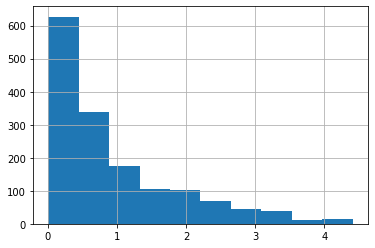

In [6]:
# Plot a histogram
df.rad_exp.hist();

The countries spending the most on R&D expenditures as a percentage of GDP are here determined by a mean of available observations. The next figure shows timelines of observations for top 10 countries.

In [13]:
# Compute average values of indicators for countries around the globe
rank = df.groupby(['geo', 'name', 'income_groups', 'world_4region'], as_index=False)[['rad_exp', 'pop_totl']].mean().sort_values(by='rad_exp', ascending=False).reset_index()
rank.drop(columns='index', inplace=True)

# Identify top 10 countries according to rad_exp indicator
rank_10 = rank.head(10)
rank_10

,geo,name,income_groups,world_4region,rad_exp,pop_totl
0,isr,Israel,high_income,asia,3.840534,6.944953e+06
1,swe,Sweden,high_income,europe,3.397525,9.198079e+06
2,fin,Finland,high_income,europe,3.252687,5.268885e+06
3,jpn,Japan,high_income,asia,3.212692,1.273554e+08
4,kor,South Korea,high_income,asia,2.892914,4.825866e+07
5,che,Switzerland,high_income,europe,2.630206,7.458052e+06
6,usa,United States,high_income,americas,2.610975,2.939698e+08
7,dnk,Denmark,high_income,europe,2.543607,5.444833e+06
8,deu,Germany,high_income,europe,2.508241,8.186463e+07
9,isl,Iceland,high_income,europe,2.449164,2.989288e+05


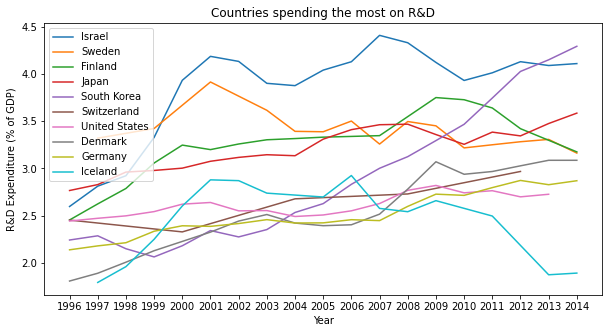

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
for name in rank_10.name:
  ax.plot(df.loc[df['name'] == name, ['time', 'rad_exp']].set_index('time'), label=name)
ax.set_xticks(range(df.time.min(), df.time.max()+1))
ax.set_xlabel('Year')
ax.set_ylabel('R&D Expenditure (% of GDP)')
ax.set_title('Countries spending the most on R&D')
ax.legend()
plt.show()

Comparing our results with more recent data from [this data story](https://www.weforum.org/agenda/2020/11/countries-spending-research-development-gdp/), we can see that 9 out of 10 countries are still on the top. South Korea is challenging Israel on the pinnacle of this rank. Finland stepped down and is replaced by Belgium. More data would be necessary to get insights into these changes but we can guess that small economies as Finland's is highly dependent on R&D expenditures of big companies, such was well known Nokia. Nokia used to bring new products to communication market but failed to address a smartphone challenge. Anyway, countries from the top of the rank help shine a light on how funding research can bolster economic competitiveness.

There are differences in average R&D spending between regions:


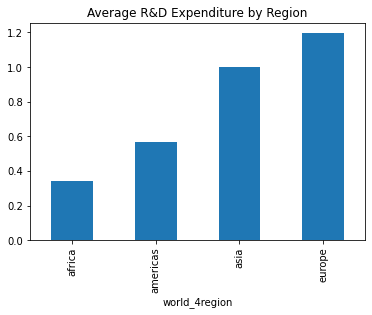

In [9]:
# Differences between regions
df.groupby('world_4region')['rad_exp'].mean().sort_values().plot(kind='bar', title='Average R&D Expenditure by Region');

THe next table shows top 3 countries from each region. Most of the innovative countries are from Asia and Europe. They belong to high income countries. The table lists also Canada and Brazil form Americas and also three most innovative counties in Africa: South Africa, Tunisia, and Morocco. These have R&D expenditures below 1% of GDP.

In [14]:
def get_subrank(rank, entity_set, top=3):
  """Takes `top` records for each category in `entity_set` in the dataframe `rank`.
  
  Args:
    rank : An ordered dataframe.
    entity_set : A set of entities in the dataframe `rank`.
    top : How many entities in each category to take.
    
  Returns:
    A new dataframe with selected records."""

  out = [rank.groupby(entity_set).get_group(entity).iloc[:top] for entity in rank[entity_set].unique()]
  return pd.concat(out)

get_subrank(rank, 'world_4region')

,geo,name,income_groups,world_4region,rad_exp,pop_totl
0,isr,Israel,high_income,asia,3.840534,6.944953e+06
3,jpn,Japan,high_income,asia,3.212692,1.273554e+08
4,kor,South Korea,high_income,asia,2.892914,4.825866e+07
1,swe,Sweden,high_income,europe,3.397525,9.198079e+06
2,fin,Finland,high_income,europe,3.252687,5.268885e+06
5,che,Switzerland,high_income,europe,2.630206,7.458052e+06
6,usa,United States,high_income,americas,2.610975,2.939698e+08
15,can,Canada,high_income,americas,1.841723,3.236225e+07
29,bra,Brazil,upper_middle_income,americas,1.069763,1.886595e+08
35,zaf,South Africa,upper_middle_income,africa,0.787004,4.869744e+07


Differencies in R&D expenditure between countries from different income groups are even bigger.

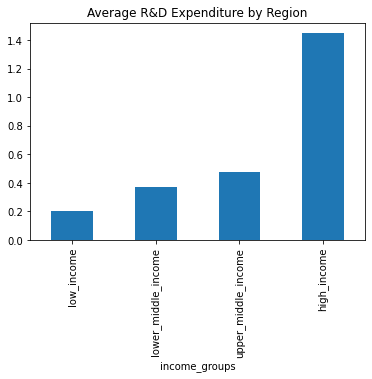

In [11]:
# Differences between income groups
df.groupby('income_groups')['rad_exp'].mean().sort_values().plot(kind='bar', title='Average R&D Expenditure by Region');

Taking into account income groups, China from Asia and Russia from Europe with R&D expenditures above 1% of GDP joins the club. In a lower middle income group and a low income group there are Ukraine from Europe, India from Asia and four countries from Africa: Tunisia, Mali, Tanzania, and Mozambique.

In [15]:
get_subrank(rank, 'income_groups')

,geo,name,income_groups,world_4region,rad_exp,pop_totl
0,isr,Israel,high_income,asia,3.840534,6.944953e+06
1,swe,Sweden,high_income,europe,3.397525,9.198079e+06
2,fin,Finland,high_income,europe,3.252687,5.268885e+06
22,chn,China,upper_middle_income,asia,1.294454,1.299178e+09
27,rus,Russia,upper_middle_income,europe,1.110064,1.446735e+08
29,bra,Brazil,upper_middle_income,americas,1.069763,1.886595e+08
32,ukr,Ukraine,lower_middle_income,europe,0.934659,4.735360e+07
38,ind,India,lower_middle_income,asia,0.750941,1.119132e+09
41,tun,Tunisia,lower_middle_income,africa,0.669672,1.043322e+07
61,mli,Mali,low_income,africa,0.460935,1.435040e+07


## R&D expenditures and country's population

We will investigate the relationship between R&D expenditures (as % of GDP) and country's population using average values accros years 1996 to 2014 which we have already seen in the `rank` dataframe.

Population data are highly skewed to the right, see the following histogram.

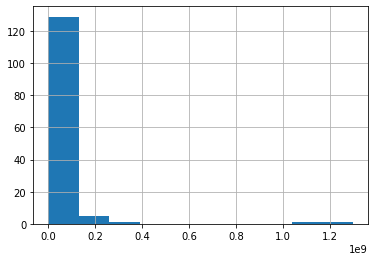

In [25]:
rank.pop_totl.hist();

The scatter plot of R&D expenditure verus total population shows clerarly that there is no relationship between these two variables. There is a lot of outlier. Some relatively small counties are over-spending much larger economies in this domain.

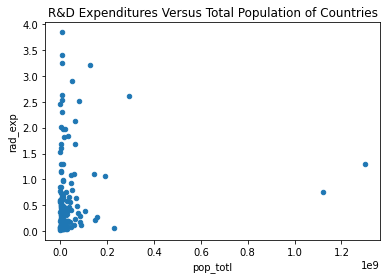

In [27]:
rank.plot(x='pop_totl', y='rad_exp', kind='scatter', title='R&D Expenditures Versus Total Population of Countries');

Transformation of population data using a logaritmic function with base 10 gives better overview of R&D expenditure versus population relationship.

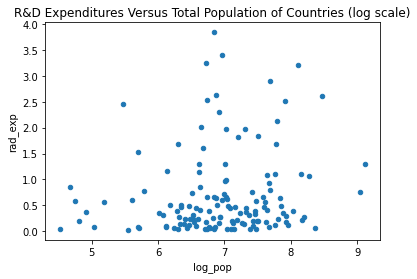

In [28]:
# Transform population data with the log function
rank['log_pop'] = rank.pop_totl.apply(np.log10)
rank.plot(x='log_pop', y='rad_exp', kind='scatter', title='R&D Expenditures Versus Total Population of Countries (log scale)');

Top 10 counties in R&D expenditure rank are spending more then 2.4 % of GDP on R&D. Relatively small countries as Israel or Sweden are out-spending much larger economies, such as Japan or United States. We can see more details in the following table.

In [31]:
# Top ten countries sorted by population
rank.query('rad_exp > 2.4').sort_values(by='pop_totl')

,geo,name,income_groups,world_4region,rad_exp,pop_totl,log_pop
9,isl,Iceland,high_income,europe,2.449164,2.989288e+05,5.475568
2,fin,Finland,high_income,europe,3.252687,5.268885e+06,6.721719
7,dnk,Denmark,high_income,europe,2.543607,5.444833e+06,6.735985
0,isr,Israel,high_income,asia,3.840534,6.944953e+06,6.841669
5,che,Switzerland,high_income,europe,2.630206,7.458052e+06,6.872625
1,swe,Sweden,high_income,europe,3.397525,9.198079e+06,6.963697
4,kor,South Korea,high_income,asia,2.892914,4.825866e+07,7.683575
8,deu,Germany,high_income,europe,2.508241,8.186463e+07,7.913096
3,jpn,Japan,high_income,asia,3.212692,1.273554e+08,8.105017
6,usa,United States,high_income,americas,2.610975,2.939698e+08,8.468303


# Conclusions <a id='conclusions'></a>

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!

# Limitations <a id='limitation'></a>